# Deep Neural Network Application - Digit Recognition

In [1]:
"""
Created on Mon May  29 12:51:07 2023

@author: Zedekiah Ambogo
"""
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn.datasets import load_digits
digits=load_digits()

<Figure size 640x480 with 0 Axes>

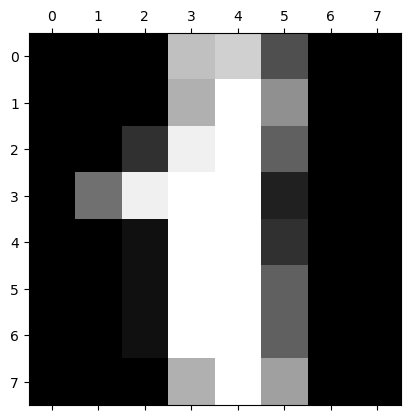

In [4]:
import pylab as pl
pl.gray()
pl.matshow(digits.images[1])
pl.show()

In [7]:
digits.images[0]

array([[ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.],
       [ 0.,  0., 13., 15., 10., 15.,  5.,  0.],
       [ 0.,  3., 15.,  2.,  0., 11.,  8.,  0.],
       [ 0.,  4., 12.,  0.,  0.,  8.,  8.,  0.],
       [ 0.,  5.,  8.,  0.,  0.,  9.,  8.,  0.],
       [ 0.,  4., 11.,  0.,  1., 12.,  7.,  0.],
       [ 0.,  2., 14.,  5., 10., 12.,  0.,  0.],
       [ 0.,  0.,  6., 13., 10.,  0.,  0.,  0.]])

In [5]:
digits.target[4]

4

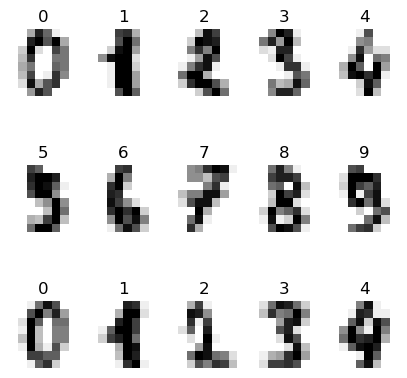

In [6]:
images_and_labels=list(zip(digits.images,digits.target))
plt.figure(figsize=(5,5))
for index,(image,label) in enumerate(images_and_labels[:15]):
    plt.subplot(3,5,index+1)
    plt.axis('off')
    plt.imshow(image,cmap=plt.cm.gray_r,interpolation='nearest')
    plt.title('%i' % label)

In [7]:
#Define variables
n_samples=len(digits.images)
print(n_samples)

x=digits.images.reshape((n_samples,-1))
print(x.shape)

1797
(1797, 64)


In [8]:
y=digits.target
print(y.shape)

(1797,)


In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)

In [10]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [11]:
X_train=X_train.T
X_test=X_test.T
y_train=y_train.reshape(y_train.shape[0],1)
y_test=y_test.reshape(y_test.shape[0],1)
y_train=y_train.T
y_test=y_test.T

In [12]:
Y_train_=np.zeros((10,y_train.shape[1]))
for i in range(y_train.shape[1]):
    Y_train_[y_train[0,i],i]=1

In [13]:
Y_test_=np.zeros((10,y_test.shape[1]))
for i in range(y_test.shape[1]):
    Y_test_[y_test[0,i],i]=1

In [14]:
n_x=X_train.shape[0]
n_h=10
n_y=Y_train_.shape[0]

In [15]:
# initialize parameters for deep neural networks
def initialize_parameters_deep(layer_dims):
    np.random.seed(3)
    parameters = {}
    L = len(layer_dims) 
    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l],layer_dims[l-1])*0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l],1))
        
        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l-1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))
    return parameters

In [16]:
def linear_forward(A, W, b):
    Z = np.dot(W,A)+b
    assert(Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)
    
    return Z, cache

In [17]:
# use ful activation functions and their derivatives
def sigmoid_(Z):
    return 1/(1+np.exp(-Z))

def relu_(Z):
    return Z*(Z>0)

def drelu_(Z):
    return 1. *(Z>0)

def dsigmoid_(Z):
    return sigmoid_(Z)*(1-sigmoid_(Z))

def sigmoid(Z):
    return sigmoid_(Z),Z

def relu(Z):
    return relu_(Z),Z

In [18]:
def linear_activation_forward(A_prev,W,b,activation):
    if activation == "sigmoid":
        Z, linear_cache = linear_forward(A_prev,W,b)
        A, activation_cache = sigmoid(Z)
        
    elif activation == "relu":
        Z, linear_cache = linear_forward(A_prev,W,b)
        A, activation_cache = relu(Z)
        
    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)
    
    return A, cache

In [19]:
# implementation of forward propogation for L layer neural network
def L_model_forward(X, parameters):
    caches = []
    A = X
    L = len(parameters) // 2   
    for l in range(1, L):
        A_prev = A 
        A, cache = linear_activation_forward(A_prev,parameters['W'+str(l)],parameters['b'+str(l)],"relu")
        caches.append(cache)
    AL, cache = linear_activation_forward(A,parameters['W'+str(L)],parameters['b'+str(L)],"sigmoid")
    caches.append(cache)
    #assert(AL.shape == (1,X.shape[1]))
    return AL, caches

In [20]:
# cost function
def compute_cost(AL, Y):
    m=Y.shape[1]
    cost = -(1/m)*np.sum((Y*np.log(AL)+(1-Y)*np.log(1-AL)))
    cost=np.squeeze(cost)
    assert(cost.shape == ())
    return cost

In [21]:
def linear_backward(dZ, cache):
    A_prev, W, b = cache
    m = A_prev.shape[1]
    dW = (1/m)*np.dot(dZ,A_prev.T)
    db = (1/m)*np.sum(dZ,axis=1,keepdims=True)
    dA_prev = np.dot(W.T,dZ)
    
    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)
    
    return dA_prev, dW, db

In [22]:
def relu_backward(dA,activation_cache):
    return dA* drelu_(activation_cache)

In [23]:
def sigmoid_backward(dA,activation_cache):
    return dA* dsigmoid_(activation_cache)

In [24]:
def linear_activation_backward(dA, cache, activation):
    linear_cache, activation_cache = cache
    if activation == "relu":
        dZ = relu_backward(dA,activation_cache)
        dA_prev, dW, db = linear_backward(dZ,linear_cache)
    
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA,activation_cache)
        dA_prev, dW, db = linear_backward(dZ,linear_cache)
    return dA_prev,dW,db

In [25]:
# back propogation for L layers
def L_model_backward(AL, Y, caches):
    grads = {}
    L = len(caches)
    m = AL.shape[1]
    #Y = Y.reshape(AL.shape)
    
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    
    current_cache = caches[L-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL,current_cache,"sigmoid")
    
    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA"+str(l+1)],current_cache,"relu")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp
    return grads

In [26]:
#update parameters
def update_parameters(parameters, grads, learning_rate):
    L = len(parameters) // 2 
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)]-(learning_rate)*grads["dW"+str(l+1)] 
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)]-(learning_rate)*grads["db"+str(l+1)]
    return parameters

In [27]:
# N layer neural network
layers_dims=[n_x,60,10,10]

def L_layer_model(X, Y, layers_dims, learning_rate = 0.005, num_iterations = 3000, print_cost=False):
    np.random.seed(1)
    costs = [] 
    
    parameters = initialize_parameters_deep(layers_dims)
    
    for i in range(0, num_iterations):
        AL, caches = L_model_forward(X, parameters)
        cost = compute_cost(AL, Y)
        grads = L_model_backward(AL, Y, caches)
        parameters = update_parameters(parameters, grads, learning_rate)
        if print_cost and i % 1000 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 1000 == 0:
            costs.append(cost)
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

Cost after iteration 0: 6.931433
Cost after iteration 1000: 3.774829
Cost after iteration 2000: 3.262610
Cost after iteration 3000: 3.249175
Cost after iteration 4000: 3.248149
Cost after iteration 5000: 3.245551
Cost after iteration 6000: 3.234484
Cost after iteration 7000: 3.108940
Cost after iteration 8000: 2.714129
Cost after iteration 9000: 2.217460
Cost after iteration 10000: 1.924373
Cost after iteration 11000: 1.561357
Cost after iteration 12000: 1.231272
Cost after iteration 13000: 0.951040
Cost after iteration 14000: 0.764662
Cost after iteration 15000: 0.618042
Cost after iteration 16000: 0.489283
Cost after iteration 17000: 0.401840
Cost after iteration 18000: 0.339931
Cost after iteration 19000: 0.289097
Cost after iteration 20000: 0.243822
Cost after iteration 21000: 0.203796
Cost after iteration 22000: 0.171250
Cost after iteration 23000: 0.145861
Cost after iteration 24000: 0.126011
Cost after iteration 25000: 0.109966
Cost after iteration 26000: 0.096728
Cost after ite

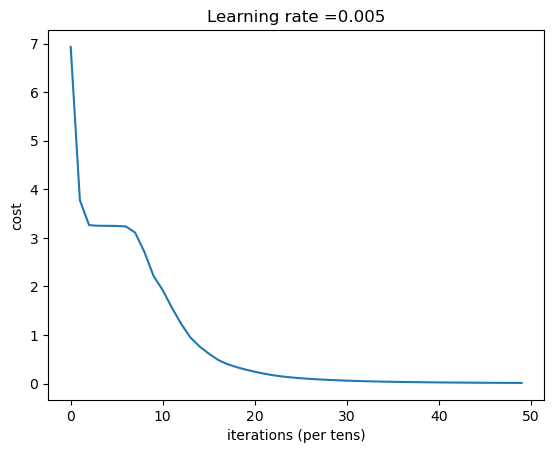

In [28]:
parameters = L_layer_model(X_train, Y_train_, layers_dims, num_iterations = 50000, print_cost = True)

In [29]:
def predict_L_layer(X,parameters):
    AL,caches=L_model_forward(X,parameters)
    prediction=np.argmax(AL,axis=0)
    return prediction.reshape(1,prediction.shape[0])

In [30]:
predictions_train_L = predict_L_layer(X_train, parameters)

In [31]:
print("Training Accuracy : "+ str(np.sum(predictions_train_L==y_train)/y_train.shape[1] * 100)+" %")

Training Accuracy : 100.0 %


In [32]:
predictions_test_L=predict_L_layer(X_test,parameters)

In [33]:
print("Testing Accuracy : "+ str(np.sum(predictions_test_L==y_test)/y_test.shape[1] * 100)+" %")

Testing Accuracy : 97.22222222222221 %


<Figure size 640x480 with 0 Axes>

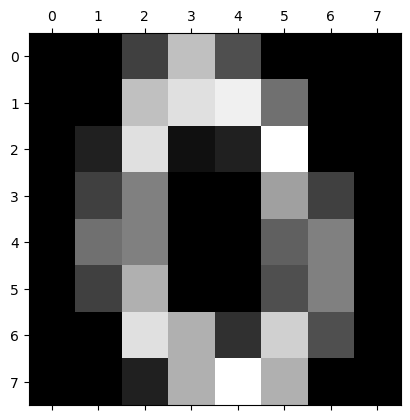

Predicted digit is : [[0]]
True digit is: 0


<Figure size 640x480 with 0 Axes>

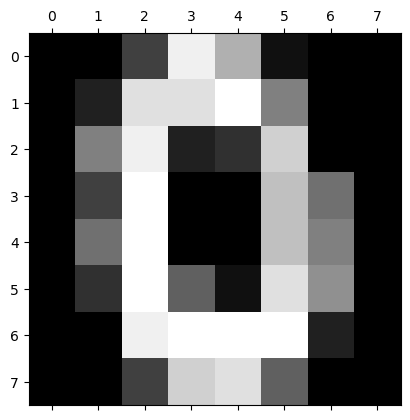

Predicted digit is : [[0]]
True digit is: 0


<Figure size 640x480 with 0 Axes>

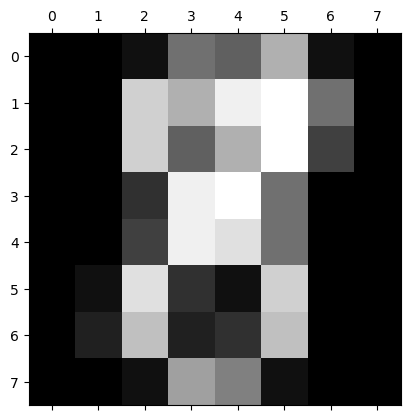

Predicted digit is : [[8]]
True digit is: 8


<Figure size 640x480 with 0 Axes>

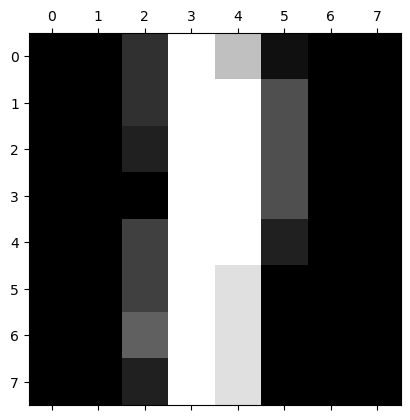

Predicted digit is : [[1]]
True digit is: 1


<Figure size 640x480 with 0 Axes>

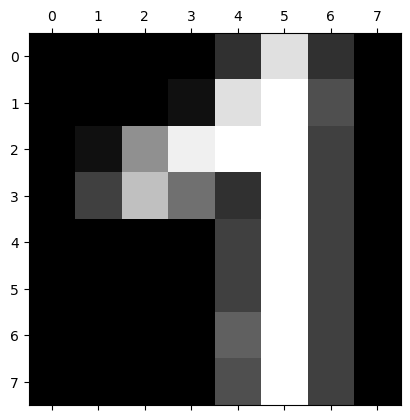

Predicted digit is : [[1]]
True digit is: 1


<Figure size 640x480 with 0 Axes>

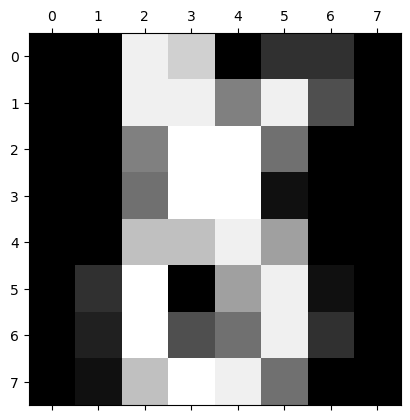

Predicted digit is : [[8]]
True digit is: 8


<Figure size 640x480 with 0 Axes>

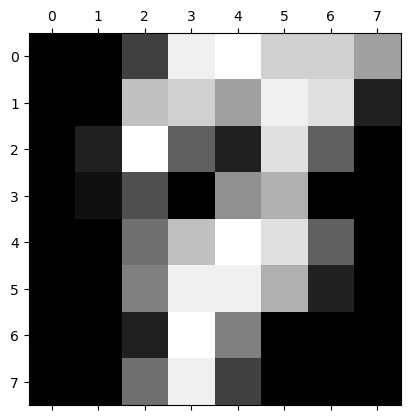

Predicted digit is : [[7]]
True digit is: 7


<Figure size 640x480 with 0 Axes>

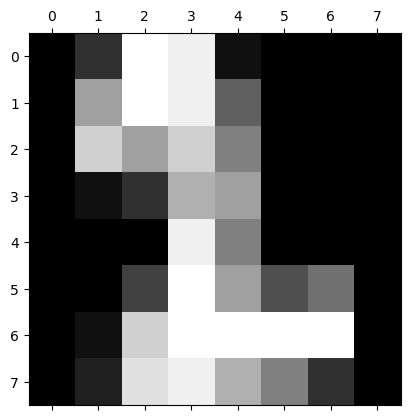

Predicted digit is : [[2]]
True digit is: 2


<Figure size 640x480 with 0 Axes>

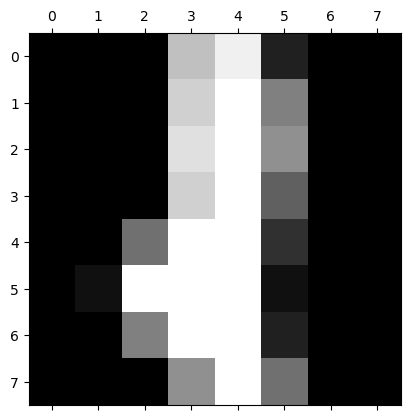

Predicted digit is : [[1]]
True digit is: 1


<Figure size 640x480 with 0 Axes>

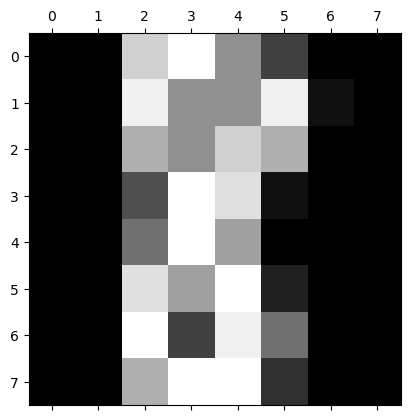

Predicted digit is : [[8]]
True digit is: 8


<Figure size 640x480 with 0 Axes>

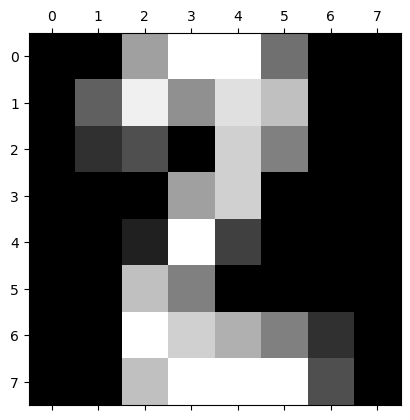

Predicted digit is : [[2]]
True digit is: 2


<Figure size 640x480 with 0 Axes>

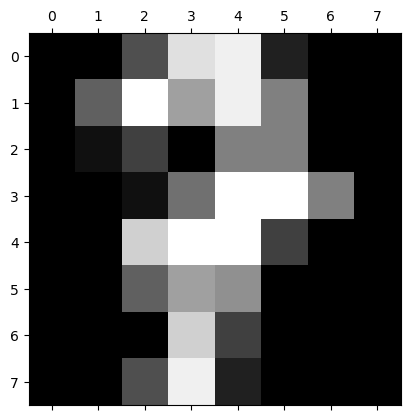

Predicted digit is : [[7]]
True digit is: 7


<Figure size 640x480 with 0 Axes>

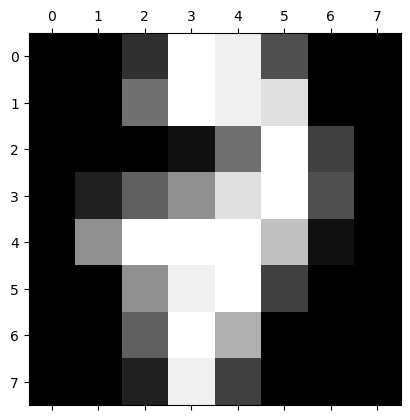

Predicted digit is : [[7]]
True digit is: 7


<Figure size 640x480 with 0 Axes>

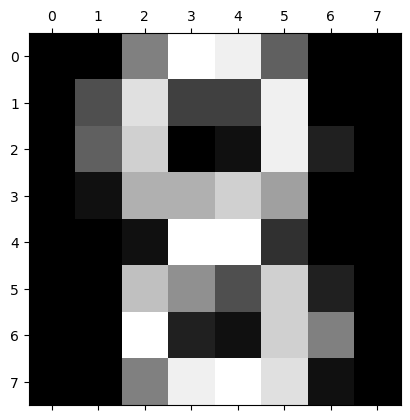

Predicted digit is : [[8]]
True digit is: 8


<Figure size 640x480 with 0 Axes>

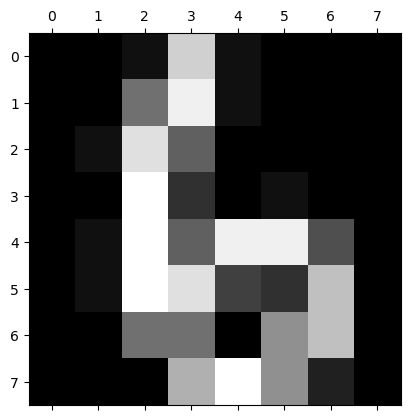

Predicted digit is : [[6]]
True digit is: 6


In [34]:
import random
for j in range(15):
    i=random.randint(0,n_samples)
    pl.gray()
    pl.matshow(digits.images[i])
    pl.show()
    img=digits.images[i].reshape((64,1)).T
    img = sc.transform(img)
    img=img.T
    predicted_digit=predict_L_layer(img,parameters)
    print('Predicted digit is : '+str(predicted_digit))
    print('True digit is: '+ str(y[i]))